In [45]:
# # Add the cloned directory to Python's path to allow importing from it
# import sys
# sys.path.append('./gen-rain')

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

# Now import using the valid module name with an underscore
from data import GaussianRainfieldGenerator
from models import JointRainDiffuser, train
from models import time_embedding, sample

ImportError: cannot import name 'sample' from 'models' (/Users/marron31/Documents/repos/gen-rain/models.py)

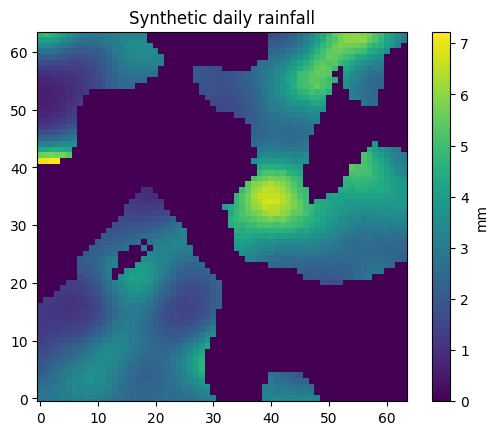

In [22]:
# ----------------------------------------------------------------
# Example usage inside Colab
# ----------------------------------------------------------------
if __name__ == "__main__":
    gen = GaussianRainfieldGenerator(
        grid_height = 64, grid_width = 64,
        length_scale = 0.1, wet_threshold = 0.4,
        amount_dist = "gamma", gamma_shape = 1.5, gamma_scale = 8.0, 
        correlated_intensity=True
    )

    # draw a single field to verify
    field = gen.sample_precip(n_samples=1,occurrence_only=False)[0,0]  # (H, W)

    # quick visual check (works in notebooks):
    import matplotlib.pyplot as plt
    plt.imshow(field.cpu(), origin="lower")
    plt.colorbar(label="mm")
    plt.title("Synthetic daily rainfall")
    plt.show()

In [ ]:
# rainset = gen.make_dataset(50_000)           # 10k synthetic days
# loader  = DataLoader(rainset, batch_size=64, shuffle=True, pin_memory=True)

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---- synthetic dataset from previous step --------------
# from synthetic_rain import GaussianRainfieldGenerator   # same file / import
gen = GaussianRainfieldGenerator(grid_height=16, grid_width=16)
rainset = gen.make_dataset(10_000)
loader  = DataLoader(rainset, batch_size=64, shuffle=True,
                      num_workers=0, pin_memory=True)

In [37]:
# ---- train ---------------------------------------------
model = JointRainDiffuser(T=1000, device=device)
train(model, loader, epochs=10, lr=1e-4, lam=10.0, device=device)

Epoch 01: Lmask=0.6764 | Lamt=0.8835
Epoch 02: Lmask=0.5752 | Lamt=0.6769
Epoch 03: Lmask=0.5495 | Lamt=0.6101
Epoch 04: Lmask=0.5376 | Lamt=0.6010
Epoch 05: Lmask=0.5319 | Lamt=0.5894
Epoch 06: Lmask=0.5329 | Lamt=0.5905
Epoch 07: Lmask=0.5245 | Lamt=0.5862
Epoch 08: Lmask=0.5237 | Lamt=0.5753
Epoch 09: Lmask=0.5242 | Lamt=0.5822
Epoch 10: Lmask=0.5160 | Lamt=0.5834


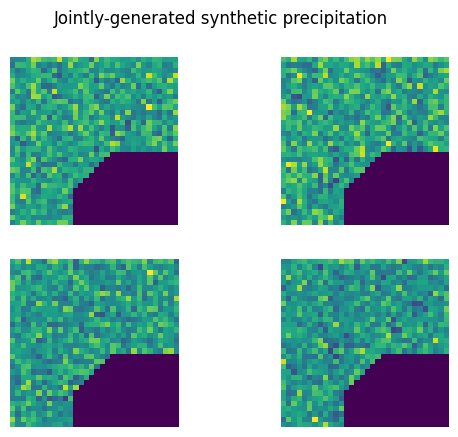

In [ ]:

fields = sample(model, n=4)               # (4,1,64,64)

import matplotlib.pyplot as plt
for i in range(4):
    plt.subplot(2,2,i+1); plt.imshow(fields[i,0], origin='lower')
    plt.axis('off')
plt.suptitle("Jointly-generated synthetic precipitation")
plt.show()